In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collection_library_utils import build_collection_library
import pickle
import torch
from data_parser import data_loader_full
import io
from matplotlib import cm
from utils import params
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Predicted/results.pkl'
with open(file_path, 'rb') as pickle_file:
    pred = CPU_Unpickler(pickle_file).load()

In [53]:
data_occupancy_all, data_flow_all, data_speed_all = data_loader_full()
X_occu_all, y_occu_all = data_occupancy_all[:, :2], data_occupancy_all[:, 2]
X_occu_all, y_occu_all = torch.tensor(X_occu_all, dtype=torch.float32, requires_grad=True), torch.tensor(y_occu_all, dtype=torch.float32).unsqueeze(1)

In [54]:
occu_recon = pred['occupancy_recon']
flow_recon = pred['flow_recon']
speed_recon = pred['speed_recon']

k_t = pred['k_t']
k_x = pred['k_x']
q_x = pred['q_x']
v_x = pred['v_x']
k_xx = pred['k_xx']
q_xx = pred['q_xx']
v_xx = pred['v_xx']

coeff = pred[('coefficients')]

### 2 mins prediction

In [55]:
z = torch.cat((occu_recon, flow_recon, speed_recon, k_x, q_x, v_x, k_xx, q_xx, v_xx), dim=1)
Theta = build_collection_library(z, poly_order=params['poly_order'], include_sine=False, device= torch.device('cpu'))
k_t_predict = torch.matmul(Theta, coeff)

In [56]:
occu_1 = occu_recon + k_t_predict

In [57]:
pred_occu_recon = torch.cat((X_occu_all, occu_recon), dim=1).detach().numpy()
pred_occu_recon = pd.DataFrame(pred_occu_recon, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_recon['TimeStep'] = pred_occu_recon['TimeStep'].astype(int)
pred_occu_recon['Station_Number'] = pred_occu_recon['Station_Number'].astype(int)
pred_occu_recon = pred_occu_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')

In [58]:
pred_occu_1 = torch.cat((X_occu_all, occu_1), dim=1).detach().numpy()
pred_occu_1 = pd.DataFrame(pred_occu_1, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_1['TimeStep'] = pred_occu_1['TimeStep'].astype(int)
pred_occu_1['Station_Number'] = pred_occu_1['Station_Number'].astype(int)
pred_occu_1 = pred_occu_1.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_1.columns = pred_occu_1.columns + 1

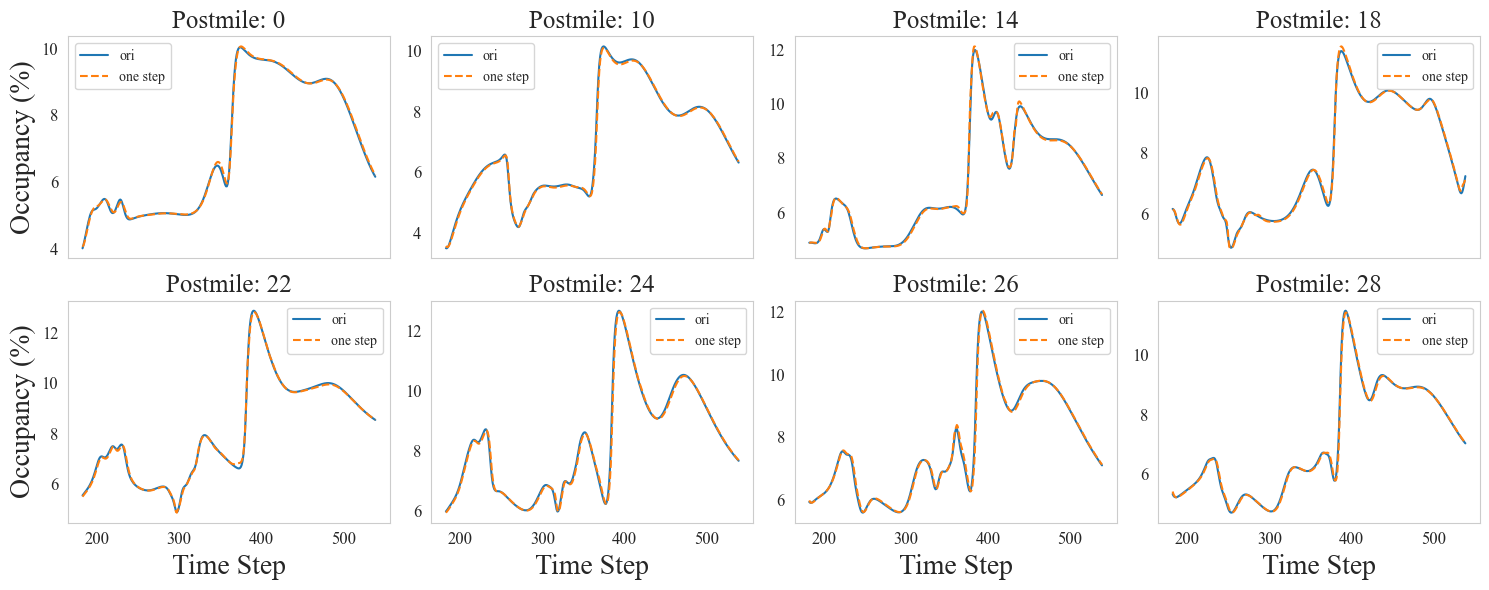

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [0, 5, 7, 9, 11, 12, 13, 14]

for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_occu_recon.iloc[col, 1:], label='ori')
    axes[i].plot(pred_occu_1.iloc[col, :-1], linestyle = '--', label='one step')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend()
    
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Occupancy (%)', fontsize=20)
    axes[i].grid(False)
    
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [60]:
rmse_occu_1_proposed = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,1:].values - pred_occu_1.iloc[:,:-1].values) ** 2))
print(rmse_occu_1_proposed)

mape_occu_1_proposed = np.nanmean(np.abs((pred_occu_recon.iloc[:,1:].values - pred_occu_1.iloc[:,:-1].values) / pred_occu_recon.iloc[:,1:].values)) * 100
print(mape_occu_1_proposed)

0.17665388
0.7642209529876709


In [11]:
# prediction based on LWR Model

In [ ]:
# prediction based on ARZ Model

### 4 mins preditction

In [12]:
from network import fullnetwork
from utils import params

In [13]:
# Load the checkpoint and load the checkpoint into the Network model
checkpoint = torch.load('Saved_Model/model_checkpoint.pt')
Network = fullnetwork(params).to(torch.device('cpu'))
Network.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [14]:
# convert pred_occu_1 to long format and input into Flow Net and Speed Net
pred_occu_1_long = pred_occu_1.transpose().stack().reset_index()
pred_occu_1_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']

In [15]:
# change pred_occu_1_long to torch.tensor type
pred_occu_1_long = torch.tensor(pred_occu_1_long.values)

In [16]:
# input pred_occu_1 into the FlowNet and SpeedNet
flow_1 = Network.FlowNet(pred_occu_1_long.float())
speed_1 = Network.SpeedNet(pred_occu_1_long.float())

In [17]:
# change flow_1 and speed_1 into pandas long format
pred_flow_1_long = torch.cat((pred_occu_1_long.float()[:, :2], flow_1), dim=1)
pred_speed_1_long = torch.cat((pred_occu_1_long.float()[:, :2], speed_1), dim=1)
pred_flow_1_long = pd.DataFrame(pred_flow_1_long.detach().numpy())
pred_speed_1_long = pd.DataFrame(pred_speed_1_long.detach().numpy())
pred_flow_1_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_speed_1_long.columns = ['TimeStep', 'Station_Number', 'Speed']
pred_flow_1_long['TimeStep'] = pred_flow_1_long['TimeStep'].astype(int)
pred_flow_1_long['Station_Number'] = pred_flow_1_long['Station_Number'].astype(int)
pred_speed_1_long['TimeStep'] = pred_speed_1_long['TimeStep'].astype(int)
pred_speed_1_long['Station_Number'] = pred_speed_1_long['Station_Number'].astype(int)

In [18]:
# convert these two to wide format
pred_flow_1 = pred_flow_1_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_speed_1 = pred_speed_1_long.pivot(index='Station_Number', columns='TimeStep', values='Speed')

# use numpy gradiant to calculate the derivatives
# first order
pred_k_x_1 = pd.DataFrame(np.gradient(pred_occu_1.to_numpy(), axis=0), index=pred_occu_1.index, columns=pred_occu_1.columns)
pred_q_x_1 = pd.DataFrame(np.gradient(pred_flow_1.to_numpy(), axis=0), index=pred_flow_1.index, columns=pred_flow_1.columns)
pred_v_x_1 = pd.DataFrame(np.gradient(pred_speed_1.to_numpy(), axis=0), index=pred_speed_1.index, columns=pred_speed_1.columns)

# second order
pred_k_xx_1 = pd.DataFrame(np.gradient(pred_k_x_1.to_numpy(), axis=0), index=pred_k_x_1.index, columns=pred_k_x_1.columns)
pred_q_xx_1 = pd.DataFrame(np.gradient(pred_q_x_1.to_numpy(), axis=0), index=pred_q_x_1.index, columns=pred_q_x_1.columns)
pred_v_xx_1 = pd.DataFrame(np.gradient(pred_v_x_1.to_numpy(), axis=0), index=pred_v_x_1.index, columns=pred_v_x_1.columns)

In [19]:
k_x_1 = pred_k_x_1.transpose().stack().reset_index()
k_x_1 = torch.tensor(k_x_1.values)[:, 2].unsqueeze(1)

q_x_1 = pred_q_x_1.transpose().stack().reset_index()
q_x_1 = torch.tensor(q_x_1.values)[:, 2].unsqueeze(1)

v_x_1 = pred_v_x_1.transpose().stack().reset_index()
v_x_1 = torch.tensor(v_x_1.values)[:, 2].unsqueeze(1)

k_xx_1 = pred_k_xx_1.transpose().stack().reset_index()
k_xx_1 = torch.tensor(k_xx_1.values)[:, 2].unsqueeze(1)

q_xx_1 = pred_q_xx_1.transpose().stack().reset_index()
q_xx_1 = torch.tensor(q_xx_1.values)[:, 2].unsqueeze(1)

v_xx_1 = pred_v_xx_1.transpose().stack().reset_index()
v_xx_1 = torch.tensor(v_xx_1.values)[:, 2].unsqueeze(1)

In [20]:
z_1 = torch.cat((occu_1, flow_1, speed_1, k_x_1, q_x_1, v_x_1, k_xx_1, q_xx_1, v_xx_1), dim=1)
Theta_1 = build_collection_library(z_1, poly_order=params['poly_order'], include_sine=False, device= torch.device('cpu')).float()
k_t_predict_1 = torch.matmul(Theta_1, coeff)

In [21]:
occu_2 = occu_1 + k_t_predict_1 

In [22]:
pred_occu_2 = torch.cat((X_occu_all, occu_2), dim=1).detach().numpy()
pred_occu_2 = pd.DataFrame(pred_occu_2, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_2['TimeStep'] = pred_occu_2['TimeStep'].astype(int)
pred_occu_2['Station_Number'] = pred_occu_2['Station_Number'].astype(int)
pred_occu_2 = pred_occu_2.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_2.columns = pred_occu_2.columns + 2

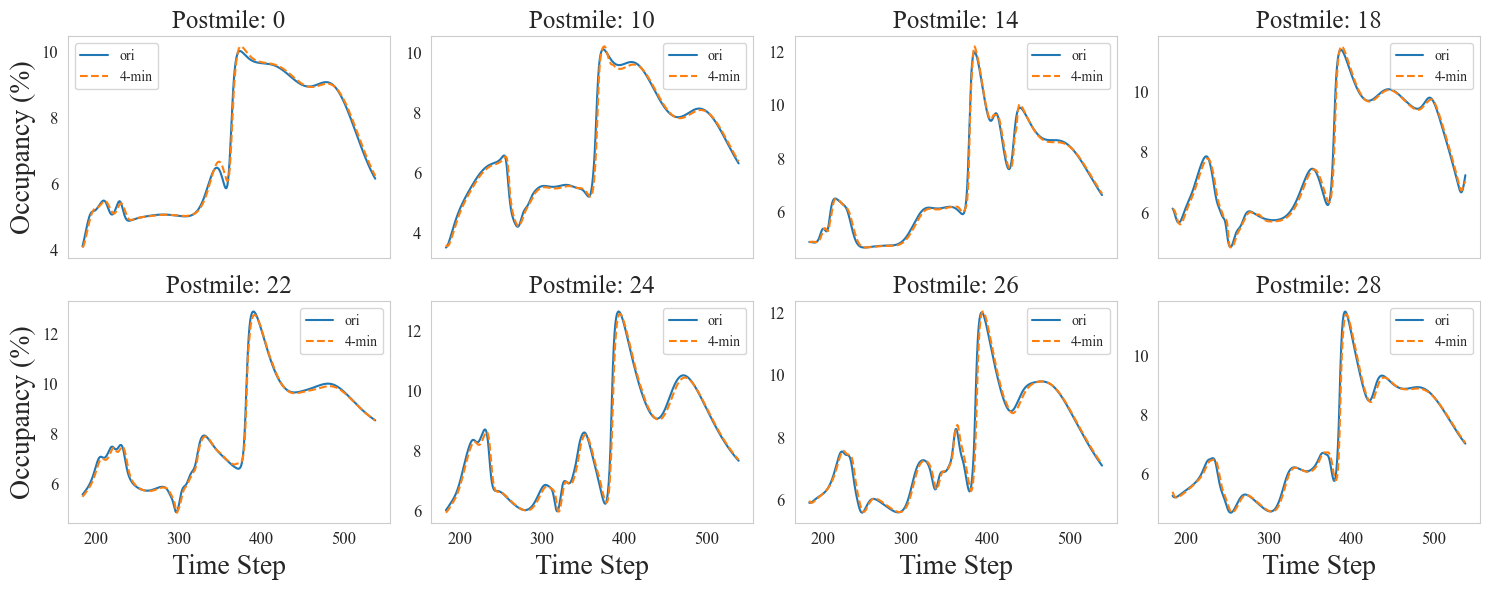

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [0, 5, 7, 9, 11, 12, 13, 14]

for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_occu_recon.iloc[col, 2:], label='ori')
    axes[i].plot(pred_occu_2.iloc[col, :-2], linestyle = '--', label='4-min')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend()
    
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Occupancy (%)', fontsize=20)
    axes[i].grid(False)
    
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [24]:
rmse_occu_2_proposed = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,2:].values - pred_occu_2.iloc[:,:-2].values) ** 2))
print(rmse_occu_2_proposed)

0.21554089


In [25]:
mape_occu_2_proposed = np.nanmean(np.abs((pred_occu_recon.iloc[:,2:].values - pred_occu_2.iloc[:,:-2].values) / pred_occu_recon.iloc[:,2:].values)) * 100
mape_occu_2_proposed

1.3745876960456371

### 6 mins prediction

In [26]:
# convert pred_occu_2 to long format and input into Flow Net and Speed Net
pred_occu_2_long = pred_occu_2.transpose().stack().reset_index()
pred_occu_2_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']

In [27]:
# change pred_occu_2_long to torch.tensor type
pred_occu_2_long = torch.tensor(pred_occu_2_long.values)

In [28]:
# input pred_occu_2 into the FlowNet and SpeedNet
flow_2 = Network.FlowNet(pred_occu_2_long.float())
speed_2 = Network.SpeedNet(pred_occu_2_long.float())

In [29]:
# change flow_2 and speed_2 into pandas long format
pred_flow_2_long = torch.cat((pred_occu_2_long.float()[:, :2], flow_1), dim=1)
pred_speed_2_long = torch.cat((pred_occu_2_long.float()[:, :2], speed_1), dim=1)
pred_flow_2_long = pd.DataFrame(pred_flow_2_long.detach().numpy())
pred_speed_2_long = pd.DataFrame(pred_speed_2_long.detach().numpy())
pred_flow_2_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_speed_2_long.columns = ['TimeStep', 'Station_Number', 'Speed']
pred_flow_2_long['TimeStep'] = pred_flow_2_long['TimeStep'].astype(int)
pred_flow_2_long['Station_Number'] = pred_flow_2_long['Station_Number'].astype(int)
pred_speed_2_long['TimeStep'] = pred_speed_2_long['TimeStep'].astype(int)
pred_speed_2_long['Station_Number'] = pred_speed_2_long['Station_Number'].astype(int)

In [30]:
# convert these two to wide format
pred_flow_2 = pred_flow_2_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_speed_2 = pred_speed_2_long.pivot(index='Station_Number', columns='TimeStep', values='Speed')

# use numpy gradiant to calculate the derivatives
# first order
pred_k_x_2 = pd.DataFrame(np.gradient(pred_occu_2.to_numpy(), axis=0), index=pred_occu_2.index, columns=pred_occu_2.columns)
pred_q_x_2 = pd.DataFrame(np.gradient(pred_flow_2.to_numpy(), axis=0), index=pred_flow_2.index, columns=pred_flow_2.columns)
pred_v_x_2 = pd.DataFrame(np.gradient(pred_speed_2.to_numpy(), axis=0), index=pred_speed_2.index, columns=pred_speed_2.columns)

# second order
pred_k_xx_2 = pd.DataFrame(np.gradient(pred_k_x_2.to_numpy(), axis=0), index=pred_k_x_2.index, columns=pred_k_x_2.columns)
pred_q_xx_2 = pd.DataFrame(np.gradient(pred_q_x_2.to_numpy(), axis=0), index=pred_q_x_2.index, columns=pred_q_x_2.columns)
pred_v_xx_2 = pd.DataFrame(np.gradient(pred_v_x_2.to_numpy(), axis=0), index=pred_v_x_2.index, columns=pred_v_x_2.columns)

In [31]:
k_x_2 = pred_k_x_2.transpose().stack().reset_index()
k_x_2 = torch.tensor(k_x_2.values)[:, 2].unsqueeze(1)

q_x_2 = pred_q_x_2.transpose().stack().reset_index()
q_x_2 = torch.tensor(q_x_2.values)[:, 2].unsqueeze(1)

v_x_2 = pred_v_x_2.transpose().stack().reset_index()
v_x_2 = torch.tensor(v_x_2.values)[:, 2].unsqueeze(1)

k_xx_2 = pred_k_xx_2.transpose().stack().reset_index()
k_xx_2 = torch.tensor(k_xx_2.values)[:, 2].unsqueeze(1)

q_xx_2 = pred_q_xx_2.transpose().stack().reset_index()
q_xx_2 = torch.tensor(q_xx_2.values)[:, 2].unsqueeze(1)

v_xx_2 = pred_v_xx_2.transpose().stack().reset_index()
v_xx_2 = torch.tensor(v_xx_2.values)[:, 2].unsqueeze(1)

In [32]:
z_2 = torch.cat((occu_2, flow_2, speed_2, k_x_2, q_x_2, v_x_2, k_xx_2, q_xx_2, v_xx_2), dim=1)
Theta_2 = build_collection_library(z_2, poly_order=params['poly_order'], include_sine=False, device= torch.device('cpu')).float()
k_t_predict_2 = torch.matmul(Theta_2, coeff)

In [33]:
occu_3 = occu_2 + k_t_predict_2
pred_occu_3 = torch.cat((X_occu_all, occu_3), dim=1).detach().numpy()
pred_occu_3 = pd.DataFrame(pred_occu_3, columns=['TimeStep', 'Station_Number', 'Occupancy'])
pred_occu_3['TimeStep'] = pred_occu_3['TimeStep'].astype(int)
pred_occu_3['Station_Number'] = pred_occu_3['Station_Number'].astype(int)
pred_occu_3 = pred_occu_3.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_3.columns = pred_occu_3.columns + 3

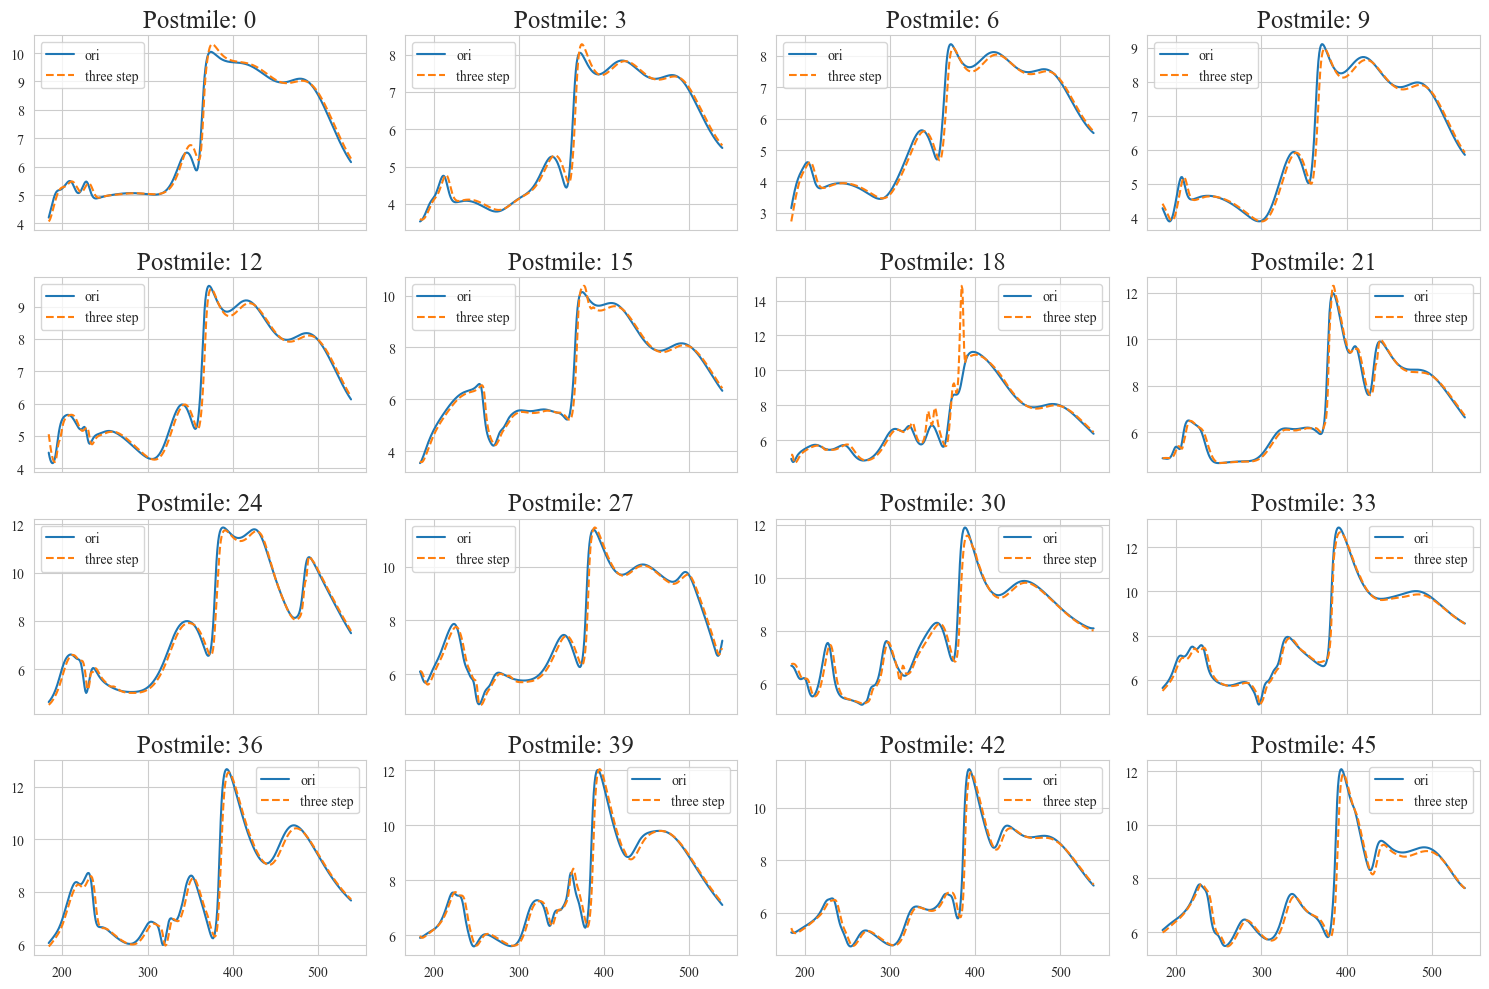

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10), sharex=True)
axes = axes.flatten()
# Plotting the data for each row in both dataframes
for i in range(16):
    axes[i].plot(pred_occu_recon.iloc[i, 3:], label='ori')
    axes[i].plot(pred_occu_3.iloc[i, :-3], linestyle = '--', label='three step')
    axes[i].set_title(f'Postmile: {i * 3}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    axes[i].legend()
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [35]:
rmse_occu_3_proposed = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,3:].values - pred_occu_3.iloc[:,:-3].values) ** 2))
print(rmse_occu_3_proposed)

mape_occu_3_proposed = np.nanmean(np.abs((pred_occu_recon.iloc[:,3:].values - pred_occu_3.iloc[:,:-3].values) / pred_occu_recon.iloc[:,3:].values)) * 100
print(mape_occu_3_proposed)

0.2773244
2.014455571770668


### 8 mins prediction

In [36]:
# convert pred_occu_3 to long format and input into Flow Net and Speed Net
pred_occu_3_long = pred_occu_3.transpose().stack().reset_index()
pred_occu_3_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
# change pred_occu_3_long to torch.tensor type
pred_occu_3_long = torch.tensor(pred_occu_3_long.values)
# input pred_occu_3 into the FlowNet and SpeedNet
flow_3 = Network.FlowNet(pred_occu_3_long.float())
speed_3 = Network.SpeedNet(pred_occu_3_long.float())
# change flow_3 and speed_3 into pandas long format
pred_flow_3_long = torch.cat((pred_occu_3_long.float()[:, :2], flow_1), dim=1)
pred_speed_3_long = torch.cat((pred_occu_3_long.float()[:, :2], speed_1), dim=1)
pred_flow_3_long = pd.DataFrame(pred_flow_3_long.detach().numpy())
pred_speed_3_long = pd.DataFrame(pred_speed_3_long.detach().numpy())
pred_flow_3_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_speed_3_long.columns = ['TimeStep', 'Station_Number', 'Speed']
pred_flow_3_long['TimeStep'] = pred_flow_3_long['TimeStep'].astype(int)
pred_flow_3_long['Station_Number'] = pred_flow_3_long['Station_Number'].astype(int)
pred_speed_3_long['TimeStep'] = pred_speed_3_long['TimeStep'].astype(int)
pred_speed_3_long['Station_Number'] = pred_speed_3_long['Station_Number'].astype(int)
# convert these two to wide format
pred_flow_3 = pred_flow_3_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_speed_3 = pred_speed_3_long.pivot(index='Station_Number', columns='TimeStep', values='Speed')

# use numpy gradiant to calculate the derivatives
# first order
pred_k_x_3 = pd.DataFrame(np.gradient(pred_occu_3.to_numpy(), axis=0), index=pred_occu_3.index,
                          columns=pred_occu_3.columns)
pred_q_x_3 = pd.DataFrame(np.gradient(pred_flow_3.to_numpy(), axis=0), index=pred_flow_3.index,
                          columns=pred_flow_3.columns)
pred_v_x_3 = pd.DataFrame(np.gradient(pred_speed_3.to_numpy(), axis=0), index=pred_speed_3.index,
                          columns=pred_speed_3.columns)

# second order
pred_k_xx_3 = pd.DataFrame(np.gradient(pred_k_x_3.to_numpy(), axis=0), index=pred_k_x_3.index,
                           columns=pred_k_x_3.columns)
pred_q_xx_3 = pd.DataFrame(np.gradient(pred_q_x_3.to_numpy(), axis=0), index=pred_q_x_3.index,
                           columns=pred_q_x_3.columns)
pred_v_xx_3 = pd.DataFrame(np.gradient(pred_v_x_3.to_numpy(), axis=0), index=pred_v_x_3.index,
                           columns=pred_v_x_3.columns)
k_x_3 = pred_k_x_3.transpose().stack().reset_index()
k_x_3 = torch.tensor(k_x_3.values)[:, 2].unsqueeze(1)

q_x_3 = pred_q_x_3.transpose().stack().reset_index()
q_x_3 = torch.tensor(q_x_3.values)[:, 2].unsqueeze(1)

v_x_3 = pred_v_x_3.transpose().stack().reset_index()
v_x_3 = torch.tensor(v_x_3.values)[:, 2].unsqueeze(1)

k_xx_3 = pred_k_xx_3.transpose().stack().reset_index()
k_xx_3 = torch.tensor(k_xx_3.values)[:, 2].unsqueeze(1)

q_xx_3 = pred_q_xx_3.transpose().stack().reset_index()
q_xx_3 = torch.tensor(q_xx_3.values)[:, 2].unsqueeze(1)

v_xx_3 = pred_v_xx_3.transpose().stack().reset_index()
v_xx_3 = torch.tensor(v_xx_3.values)[:, 2].unsqueeze(1)
z_3 = torch.cat((occu_3, flow_3, speed_3, k_x_3, q_x_3, v_x_3, k_xx_3, q_xx_3, v_xx_3), dim=1)
Theta_3 = build_collection_library(z_3, poly_order=params['poly_order'], include_sine=False,
                                   device=torch.device('cpu')).float()
k_t_predict_3 = torch.matmul(Theta_3, coeff)
occu_4 = occu_3 + k_t_predict_3
pred_occu_4 = torch.cat((X_occu_all, occu_4), dim=1).detach().numpy()
pred_occu_4 = pd.DataFrame(pred_occu_4, columns=['TimeStep', 'Station_Number', 'Occupancy'])
pred_occu_4['TimeStep'] = pred_occu_4['TimeStep'].astype(int)
pred_occu_4['Station_Number'] = pred_occu_4['Station_Number'].astype(int)
pred_occu_4 = pred_occu_4.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_4.columns = pred_occu_4.columns + 4

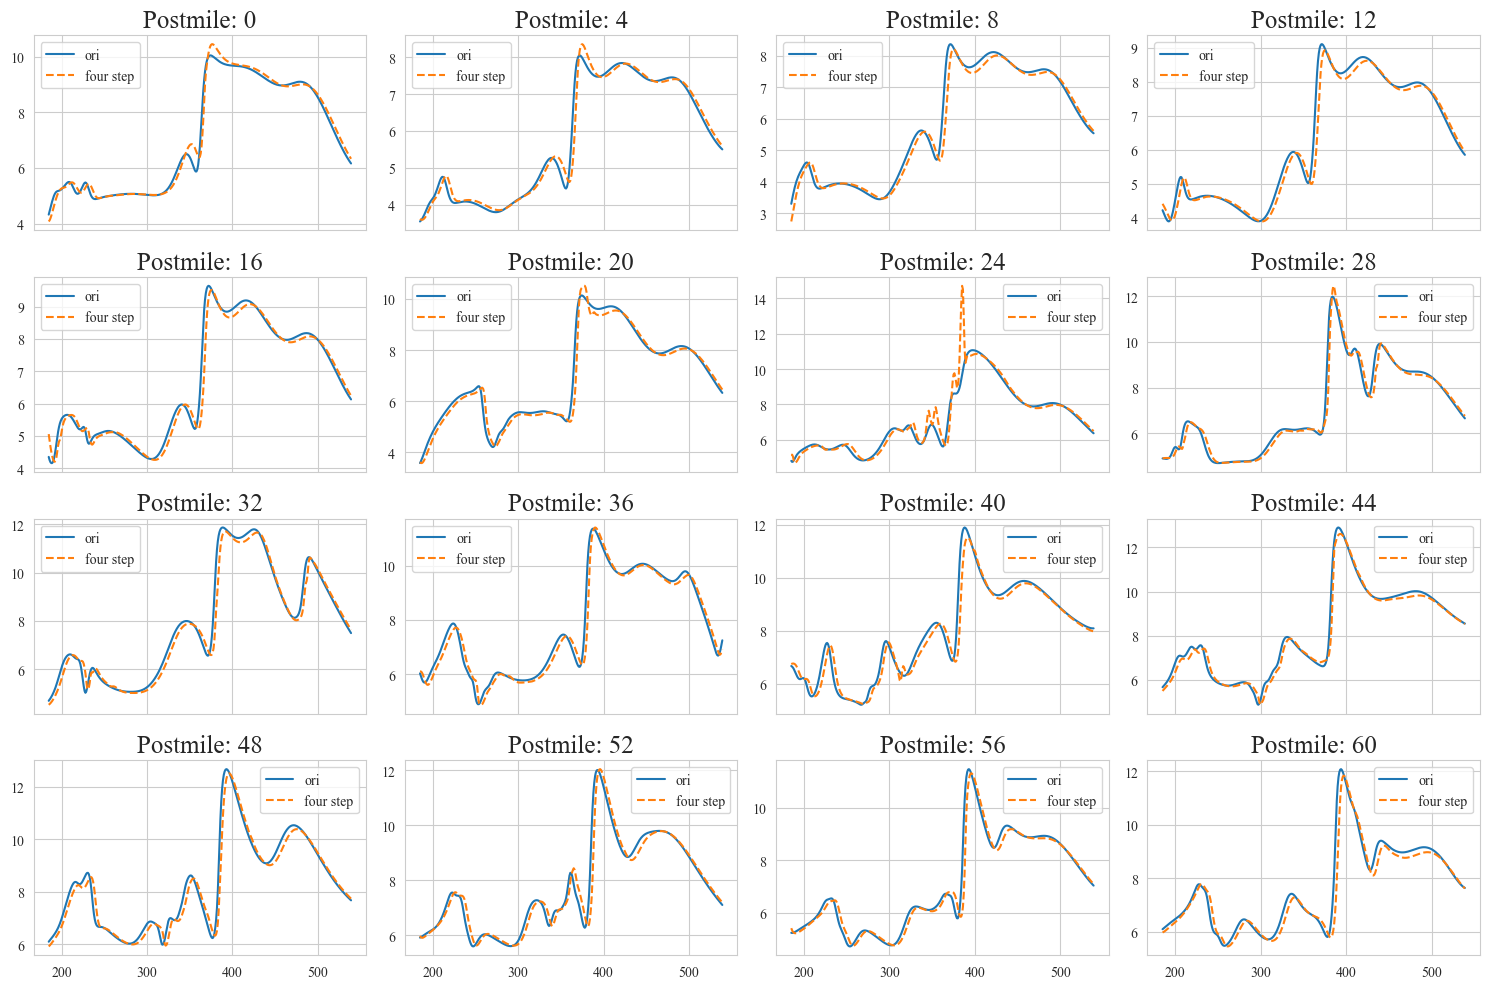

In [37]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10), sharex=True)
axes = axes.flatten()
# Plotting the data for each row in both dataframes
for i in range(16):
    axes[i].plot(pred_occu_recon.iloc[i, 4:], label='ori')
    axes[i].plot(pred_occu_4.iloc[i, :-4], linestyle='--', label='four step')
    axes[i].set_title(f'Postmile: {i * 4}', fontsize=18)
    # axes[i].set_ylim(-0.6, 0.8)
    axes[i].legend()
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [38]:
rmse_occu_4_proposed = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,4:].values - pred_occu_4.iloc[:,:-4].values) ** 2))
print(rmse_occu_4_proposed)

mape_occu_4_proposed = np.nanmean(np.abs((pred_occu_recon.iloc[:,4:].values - pred_occu_4.iloc[:,:-4].values) / pred_occu_recon.iloc[:,4:].values)) * 100
print(mape_occu_4_proposed)

0.34848002
2.650694362819195


### 10 mins prediction

In [39]:
# convert pred_occu_4 to long format and input into Flow Net and Speed Net
pred_occu_4_long = pred_occu_4.transpose().stack().reset_index()
pred_occu_4_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
# change pred_occu_4_long to torch.tensor type
pred_occu_4_long = torch.tensor(pred_occu_4_long.values)
# input pred_occu_4 into the FlowNet and SpeedNet
flow_4 = Network.FlowNet(pred_occu_4_long.float())
speed_4 = Network.SpeedNet(pred_occu_4_long.float())
# change flow_4 and speed_4 into pandas long format
pred_flow_4_long = torch.cat((pred_occu_4_long.float()[:, :2], flow_1), dim=1)
pred_speed_4_long = torch.cat((pred_occu_4_long.float()[:, :2], speed_1), dim=1)
pred_flow_4_long = pd.DataFrame(pred_flow_4_long.detach().numpy())
pred_speed_4_long = pd.DataFrame(pred_speed_4_long.detach().numpy())
pred_flow_4_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_speed_4_long.columns = ['TimeStep', 'Station_Number', 'Speed']
pred_flow_4_long['TimeStep'] = pred_flow_4_long['TimeStep'].astype(int)
pred_flow_4_long['Station_Number'] = pred_flow_4_long['Station_Number'].astype(int)
pred_speed_4_long['TimeStep'] = pred_speed_4_long['TimeStep'].astype(int)
pred_speed_4_long['Station_Number'] = pred_speed_4_long['Station_Number'].astype(int)
# convert these two to wide format
pred_flow_4 = pred_flow_4_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_speed_4 = pred_speed_4_long.pivot(index='Station_Number', columns='TimeStep', values='Speed')

# use numpy gradiant to calculate the derivatives
# first order
pred_k_x_4 = pd.DataFrame(np.gradient(pred_occu_4.to_numpy(), axis=0), index=pred_occu_4.index,
                          columns=pred_occu_4.columns)
pred_q_x_4 = pd.DataFrame(np.gradient(pred_flow_4.to_numpy(), axis=0), index=pred_flow_4.index,
                          columns=pred_flow_4.columns)
pred_v_x_4 = pd.DataFrame(np.gradient(pred_speed_4.to_numpy(), axis=0), index=pred_speed_4.index,
                          columns=pred_speed_4.columns)

# second order
pred_k_xx_4 = pd.DataFrame(np.gradient(pred_k_x_4.to_numpy(), axis=0), index=pred_k_x_4.index,
                           columns=pred_k_x_4.columns)
pred_q_xx_4 = pd.DataFrame(np.gradient(pred_q_x_4.to_numpy(), axis=0), index=pred_q_x_4.index,
                           columns=pred_q_x_4.columns)
pred_v_xx_4 = pd.DataFrame(np.gradient(pred_v_x_4.to_numpy(), axis=0), index=pred_v_x_4.index,
                           columns=pred_v_x_4.columns)
k_x_4 = pred_k_x_4.transpose().stack().reset_index()
k_x_4 = torch.tensor(k_x_4.values)[:, 2].unsqueeze(1)

q_x_4 = pred_q_x_4.transpose().stack().reset_index()
q_x_4 = torch.tensor(q_x_4.values)[:, 2].unsqueeze(1)

v_x_4 = pred_v_x_4.transpose().stack().reset_index()
v_x_4 = torch.tensor(v_x_4.values)[:, 2].unsqueeze(1)

k_xx_4 = pred_k_xx_4.transpose().stack().reset_index()
k_xx_4 = torch.tensor(k_xx_4.values)[:, 2].unsqueeze(1)

q_xx_4 = pred_q_xx_4.transpose().stack().reset_index()
q_xx_4 = torch.tensor(q_xx_4.values)[:, 2].unsqueeze(1)

v_xx_4 = pred_v_xx_4.transpose().stack().reset_index()
v_xx_4 = torch.tensor(v_xx_4.values)[:, 2].unsqueeze(1)
z_4 = torch.cat((occu_4, flow_4, speed_4, k_x_4, q_x_4, v_x_4, k_xx_4, q_xx_4, v_xx_4), dim=1)
Theta_4 = build_collection_library(z_4, poly_order=params['poly_order'], include_sine=False,
                                   device=torch.device('cpu')).float()
k_t_predict_4 = torch.matmul(Theta_4, coeff)
occu_5 = occu_4 + k_t_predict_4
pred_occu_5 = torch.cat((X_occu_all, occu_5), dim=1).detach().numpy()
pred_occu_5 = pd.DataFrame(pred_occu_5, columns=['TimeStep', 'Station_Number', 'Occupancy'])
pred_occu_5['TimeStep'] = pred_occu_5['TimeStep'].astype(int)
pred_occu_5['Station_Number'] = pred_occu_5['Station_Number'].astype(int)
pred_occu_5 = pred_occu_5.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
# add step size to column index
pred_occu_5.columns = pred_occu_5.columns + 5

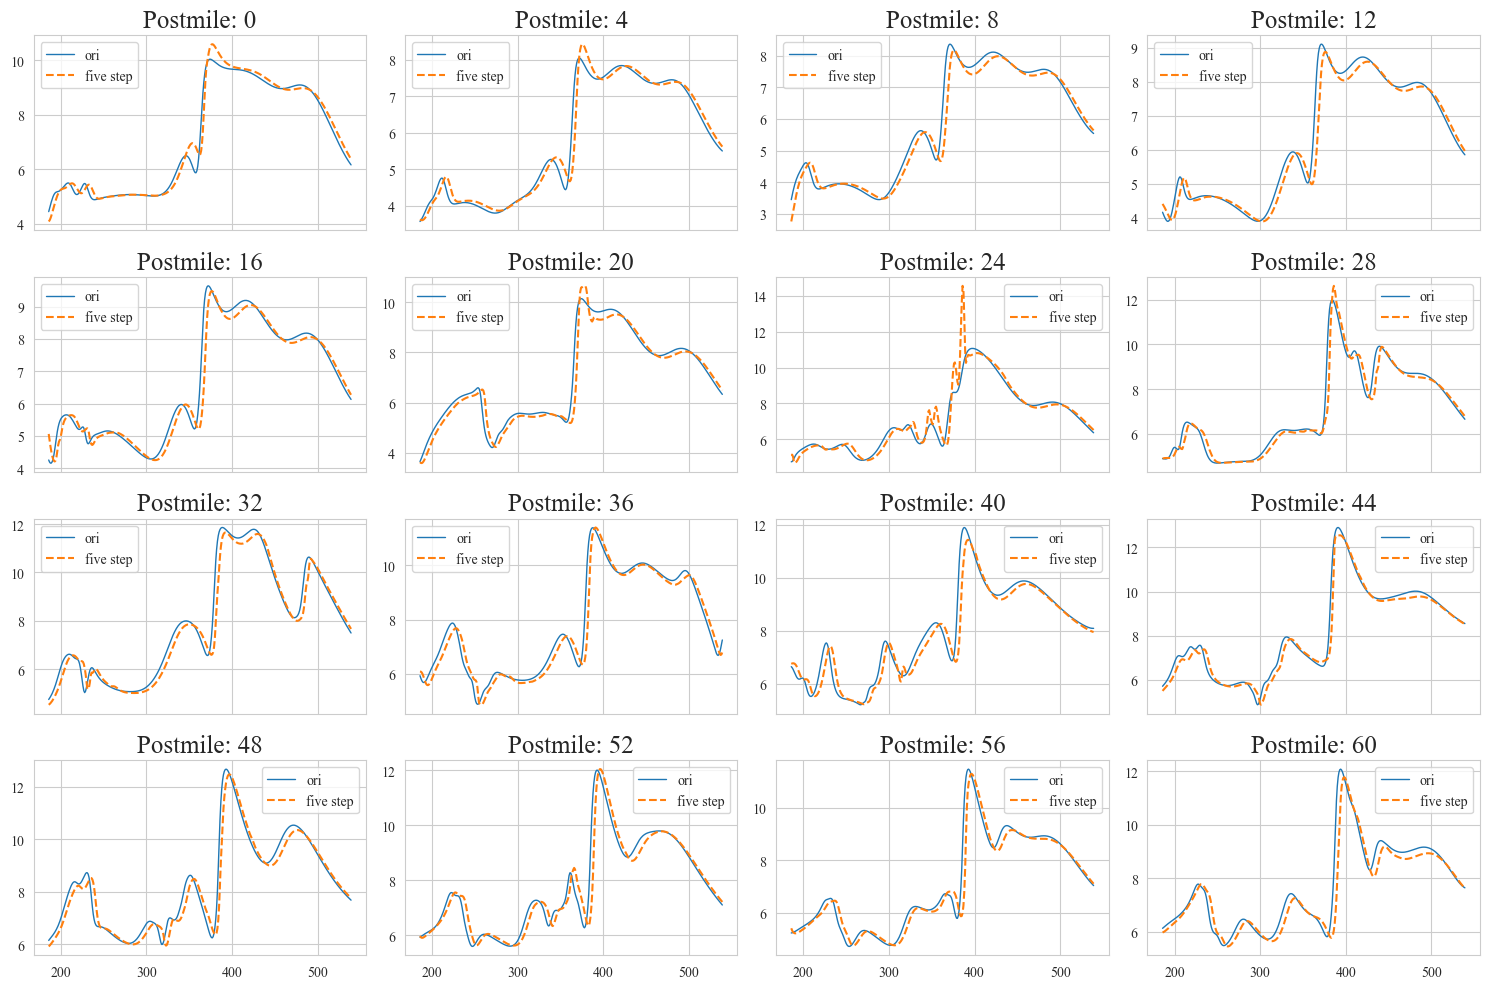

In [40]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10), sharex=True)
axes = axes.flatten()
# Plotting the data for each row in both dataframes
for i in range(16):
    axes[i].plot(pred_occu_recon.iloc[i, 5:], linewidth = 1 ,label='ori')
    axes[i].plot(pred_occu_5.iloc[i, :-5], linestyle='--', label='five step')
    axes[i].set_title(f'Postmile: {i * 4}', fontsize=18)
    # axes[i].set_ylim(-0.6, 0.8)
    axes[i].legend()
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [41]:
rmse_occu_5_proposed = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,5:].values - pred_occu_5.iloc[:,:-5].values) ** 2))
print(rmse_occu_5_proposed)

mape_occu_5_proposed = np.nanmean(np.abs((pred_occu_recon.iloc[:,5:].values - pred_occu_5.iloc[:,:-5].values) / pred_occu_recon.iloc[:,5:].values)) * 100
print(mape_occu_5_proposed)

0.42259786
3.2701414078474045


In [50]:
# combine accuracy data into a dataframe
data = {
    'Prediction Length': ['RMSE(%)', 'MAPE(%)'],
    '2-min prediction': [rmse_occu_1_proposed, mape_occu_1_proposed],
    '4-min prediction': [rmse_occu_2_proposed, mape_occu_2_proposed],
    '6-min prediction': [rmse_occu_3_proposed, mape_occu_3_proposed],
    '8-min prediction': [rmse_occu_4_proposed, mape_occu_4_proposed],
    '10-min prediction': [rmse_occu_5_proposed, mape_occu_5_proposed]
}
df = pd.DataFrame(data)
df.iloc[:, 1:] = df.iloc[:, 1:].round(2)
df.to_csv('Tables/Prediction_Error_Proposed.csv', index=False)

### Combine Predictions Plots

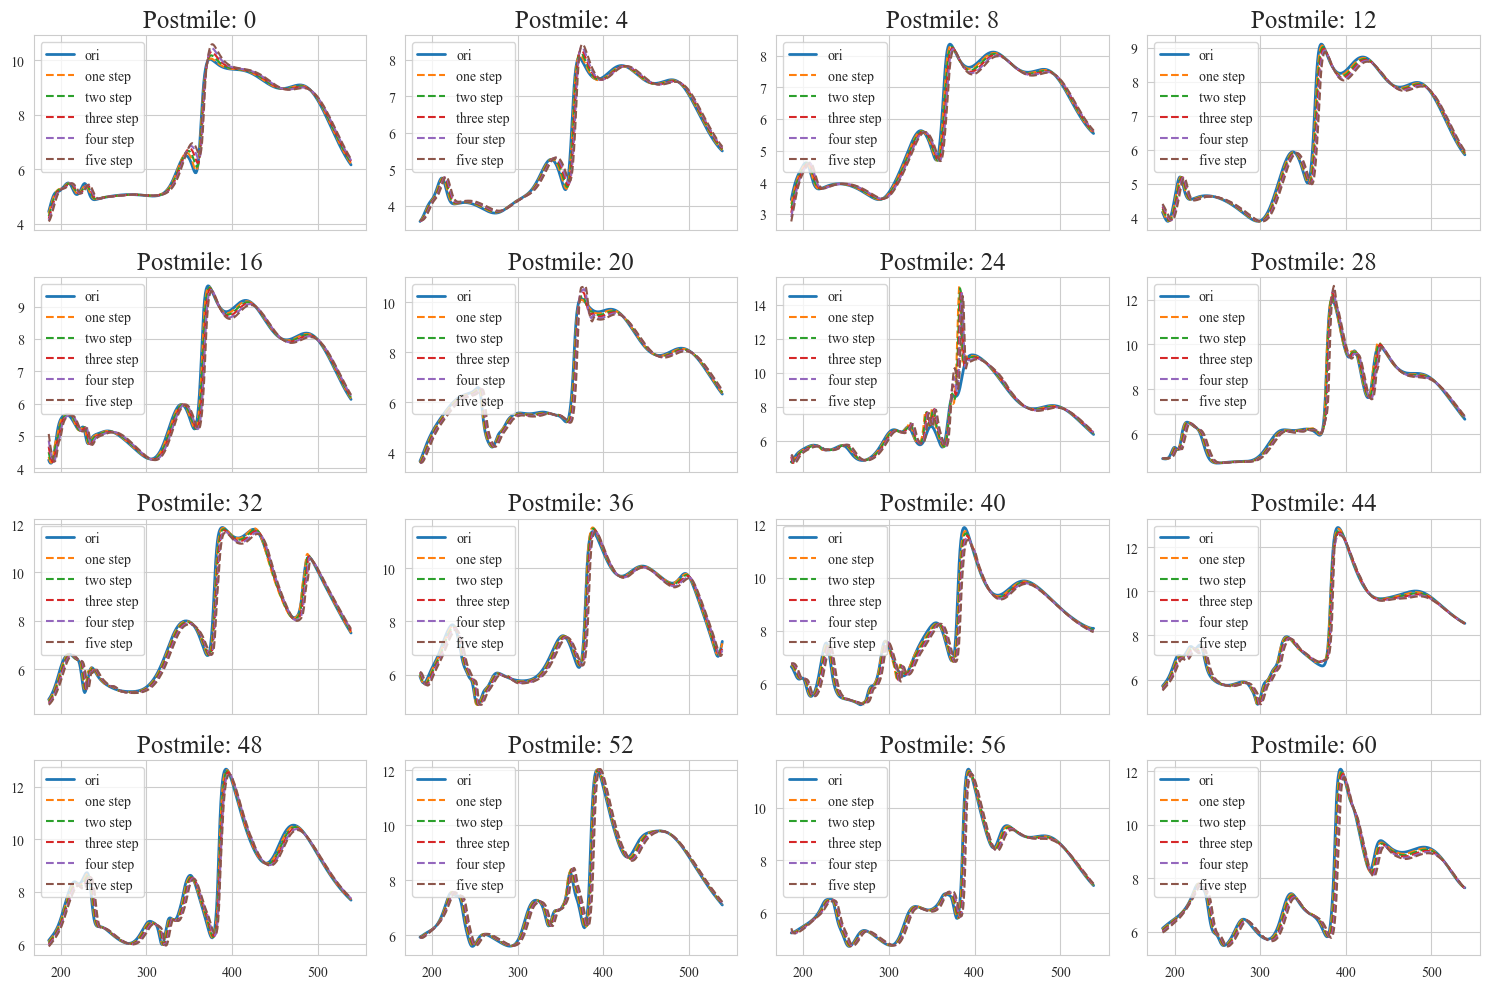

In [59]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10), sharex=True)
axes = axes.flatten()
# Plotting the data for each row in both dataframes
for i in range(16):
    axes[i].plot(pred_occu_recon.iloc[i, 5:], linewidth = 2 ,label='ori')
    axes[i].plot(pred_occu_1.iloc[i, 4:-1], linestyle='--', label='one step')
    axes[i].plot(pred_occu_2.iloc[i, 3:-2], linestyle='--', label='two step')
    axes[i].plot(pred_occu_3.iloc[i, 2:-3], linestyle='--', label='three step')
    axes[i].plot(pred_occu_4.iloc[i, 1:-4], linestyle='--', label='four step')
    axes[i].plot(pred_occu_5.iloc[i, :-5], linestyle='--', label='five step')
    axes[i].set_title(f'Postmile: {i * 4}', fontsize=18)
    # axes[i].set_ylim(-0.6, 0.8)
    axes[i].legend()
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
fig.savefig("Figures/predictions.png", dpi=300, bbox_inches='tight')